In [1]:
# this code is generated by the Domino Code Assist toolbar button
import domino_code_assist as dca
dca.init()

Cannot show ipywidgets in text

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [3]:
# Read in the csv fisle using pandas
df = pd.read_csv('../data/credit_card_default.csv')

# Make a copy of the dataframe
data = df.copy()

In [4]:
# imputing the values with median (due to presence of outliers)
median = data.iloc[:,2].median()
data.iloc[:,2] = data.iloc[:,2].fillna(median)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

### Correlation Matrix

In [5]:
corr_matrix = data.corr()
corr_matrix.iloc[:,0].sort_values(ascending=False)

ID                            1.000000
BILL_AMT4                     0.040351
EDUCATION                     0.039177
PAY_AMT3                      0.039151
LIMIT_BAL                     0.026179
BILL_AMT3                     0.024354
BILL_AMT1                     0.019389
AGE                           0.018678
SEX                           0.018497
BILL_AMT2                     0.017982
BILL_AMT6                     0.016730
BILL_AMT5                     0.016705
PAY_AMT1                      0.009742
PAY_AMT2                      0.008406
PAY_AMT4                      0.007793
PAY_AMT6                      0.003000
PAY_AMT5                      0.000652
PAY_4                        -0.002735
PAY_2                        -0.011215
default payment next month   -0.013952
PAY_3                        -0.018494
PAY_6                        -0.020270
PAY_5                        -0.022199
MARRIAGE                     -0.029079
PAY_0                        -0.030575
Name: ID, dtype: float64

### Data Cleaning - Imputer

In [6]:
##handling missing values
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
imputer.fit(data)

SimpleImputer(strategy='median')

### Data Cleaning Pipeline

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

def num_pipeline_transformer(data):
    '''
    Function to process numerical transformations
    Argument:
        data: original dataframe 
    Returns:
        num_attrs: numerical dataframe
        num_pipeline: numerical pipeline object
        
    '''
    numerics = ['float64', 'int64']

    num_attrs = data.select_dtypes(include=numerics)

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
        ])
    return num_attrs, num_pipeline

In [8]:
def pipeline_transformer(data):
    '''
    Complete transformation pipeline for both
    nuerical and categorical data.
    
    Argument:
        data: original dataframe 
    Returns:
        prepared_data: transformed data, ready to use
    '''
    
    num_attrs, num_pipeline = num_pipeline_transformer(data)
    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, list(num_attrs))
        ])
    prepared_data = full_pipeline.fit_transform(data)
    
    return prepared_data

### Create train and test sets

In [9]:
from sklearn.model_selection import train_test_split

X = data.drop('default payment next month', axis=1)
y = data['default payment next month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_train = pipeline_transformer(X_train)
X_test = pipeline_transformer(X_test)

### Train Model

### Logistic Regression

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, log_loss, plot_roc_curve, precision_recall_curve, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score

log_reg = LogisticRegression(penalty='l1', solver='liblinear')
log_reg.fit(X_train, y_train)

# testing the predictions with first 5 rows
sample_data = X_test[:5,]
sample_labels = y_test[:5]
# sample_data_prepared = pipeline_transformer(sample_data)

print("Sample Default Predictions: ", log_reg.predict(sample_data))
print("Sample Default Predicted Default Probabilities: ", log_reg.predict_proba(sample_data))

# Print Cross Validation Scores on Training Set

log_reg_clf_scores = cross_val_score(log_reg, 
                                     X_train, 
                                     y_train, 
                                     scoring="roc_auc", 
                                     cv = 5)

print('\n LogisticRegression classifier AUC on CV Folds: {}'.format(log_reg_clf_scores))
print('\n LogisticRegression Classifier AUC on CV Average: {}'.format(round(np.mean(log_reg_clf_scores), 3)))

# Print Model AUC on test set
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test)[:, 1])

print('\n LogisticRegression classifier AUC on test set: {}'.format(round(auc, 3)))

Sample Default Predictions:  [0 0 0 0 0]
Sample Default Predicted Default Probabilities:  [[0.76072644 0.23927356]
 [0.83250933 0.16749067]
 [0.79312533 0.20687467]
 [0.78045715 0.21954285]
 [0.80726552 0.19273448]]

 LogisticRegression classifier AUC on CV Folds: [0.73209177 0.72318142 0.72700729 0.70734087 0.71759124]

 LogisticRegression Classifier AUC on CV Average: 0.721

 LogisticRegression classifier AUC on test set: 0.725


### Decision Tree Classifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

# testing the predictions with first 5 rows
sample_data = X_test[:5,]
sample_labels = y_test[:5]
# sample_data_prepared = pipeline_transformer(sample_data)

print("Sample Default Predictions: ", tree_clf.predict(sample_data))
print("Sample Default Predicted Default Probabilities: ", tree_clf.predict_proba(sample_data))

# Print Cross Validation Scores on Training Set

tree_clf_scores = cross_val_score(tree_clf, 
                                     X_train, 
                                     y_train, 
                                     scoring="roc_auc", 
                                     cv = 5)

print('\n Decision Tree Classifier AUC on CV Folds: {}'.format(tree_clf_scores))
print('\n Decision Tree Classifier AUC on CV Average: {}'.format(round(np.mean(tree_clf_scores), 3)))

# Print Model AUC on test set
auc = roc_auc_score(y_test, tree_clf.predict_proba(X_test)[:, 1])

print('\n Decision Tree Classifier AUC on test set: {}'.format(round(auc, 3)))

Sample Default Predictions:  [0 0 1 0 0]
Sample Default Predicted Default Probabilities:  [[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]

 Decision Tree Classifier AUC on CV Folds: [0.62019275 0.60685205 0.61476387 0.62299709 0.62019575]

 Decision Tree Classifier AUC on CV Average: 0.617

 Decision Tree Classifier AUC on test set: 0.599


### Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

# testing the predictions with first 5 rows
sample_data = X_test[:5,]
sample_labels = y_test[:5]
# sample_data_prepared = pipeline_transformer(sample_data)

print("Sample Default Predictions: ", rf_clf.predict(sample_data))
print("Sample Default Predicted Default Probabilities: ", rf_clf.predict_proba(sample_data))

# Print Cross Validation Scores on Training Set

rf_clf_scores = cross_val_score(rf_clf, 
                                X_train, 
                                y_train, 
                                scoring="roc_auc", 
                                cv = 5)

print('\n Decision Tree Classifier AUC on CV Folds: {}'.format(rf_clf_scores))
print('\n Decision Tree Classifier AUC on CV Average: {}'.format(round(np.mean(rf_clf_scores), 3)))

# Print Model AUC on test set
auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])

print('\n Decision Tree Classifier AUC on test set: {}'.format(round(auc, 3)))

Sample Default Predictions:  [0 0 0 0 0]
Sample Default Predicted Default Probabilities:  [[0.75 0.25]
 [0.84 0.16]
 [0.78 0.22]
 [0.84 0.16]
 [0.7  0.3 ]]

 Decision Tree Classifier AUC on CV Folds: [0.77191541 0.76680234 0.77084614 0.75774927 0.75963495]

 Decision Tree Classifier AUC on CV Average: 0.765

 Decision Tree Classifier AUC on test set: 0.765


### XGB Classifier

In [13]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)

# testing the predictions with first 5 rows
sample_data = X_test[:5,]
sample_labels = y_test[:5]
# sample_data_prepared = pipeline_transformer(sample_data)

print("Sample Default Predictions: ", xgb_clf.predict(sample_data))
print("Sample Default Predicted Default Probabilities: ", xgb_clf.predict_proba(sample_data))

# Print Cross Validation Scores on Training Set

xgb_clf_scores = cross_val_score(xgb_clf, 
                                X_train, 
                                y_train, 
                                scoring="roc_auc", 
                                cv = 5)

print('\n XGB Classifier AUC on CV Folds: {}'.format(xgb_clf_scores))
print('\n XGB Classifier AUC on CV Average: {}'.format(round(np.mean(xgb_clf_scores), 3)))

# Print Model AUC on test set
auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])

print('\n Decision Tree Classifier AUC on test set: {}'.format(round(auc, 3)))


Sample Default Predictions:  [0 0 0 0 0]
Sample Default Predicted Default Probabilities:  [[0.7221775  0.27782246]
 [0.9275888  0.07241119]
 [0.852527   0.14747299]
 [0.92451227 0.07548771]
 [0.8298368  0.1701632 ]]

 XGB Classifier AUC on CV Folds: [0.76303024 0.76063626 0.77204563 0.75496188 0.75071821]

 XGB Classifier AUC on CV Average: 0.76

 Decision Tree Classifier AUC on test set: 0.756


### Tune the Selected Model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [100, 200, 500],
     'max_depth': [5, 6, 7],
     'learning_rate': [0.01, 0.1, 0.3]},
  ]

xgb_clf = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_clf, param_grid,
                           scoring='neg_log_loss',
                           return_train_score=True,
                           cv=5,
                           )

grid_search.fit(X_train, y_train)

In [ ]:
cv_scores = grid_search.cv_results_

In [20]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}

In [21]:
import numpy as np
for mean_score, params in zip(cv_scores['mean_test_score'], cv_scores['params']):
    print(-mean_score, params)

0.4817029054277572 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
0.44011709443965363 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}
0.4282536593031379 {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
0.48085751772371693 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 100}
0.43957657856764787 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}
0.4288702301841359 {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 500}
0.4800951511016236 {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}
0.4393808603902065 {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
0.43026819800040617 {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 500}
0.42958428975157625 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
0.4323216526130381 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
0.4473819742525582 {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
0.4313626719709598 {'learning_rate': 0

In [22]:
# feature importances
feature_importances = grid_search.best_estimator_.feature_importances_

numerics = ['float64', 'int64']
num_attrs = list(data.iloc[:,1:].select_dtypes(include=numerics))

attrs = num_attrs
sorted(zip(attrs, feature_importances), reverse=True)

[('default payment next month', 0.01430395),
 ('SEX', 0.02286214),
 ('PAY_AMT6', 0.011960013),
 ('PAY_AMT5', 0.0184059),
 ('PAY_AMT4', 0.023492992),
 ('PAY_AMT3', 0.022519886),
 ('PAY_AMT2', 0.020446869),
 ('PAY_AMT1', 0.012113732),
 ('PAY_6', 0.021253673),
 ('PAY_5', 0.04408151),
 ('PAY_4', 0.03909812),
 ('PAY_3', 0.1597375),
 ('PAY_2', 0.42664042),
 ('PAY_0', 0.012705892),
 ('MARRIAGE', 0.013841454),
 ('LIMIT_BAL', 0.012132663),
 ('EDUCATION', 0.013393641),
 ('BILL_AMT6', 0.011862274),
 ('BILL_AMT5', 0.011406212),
 ('BILL_AMT4', 0.012943077),
 ('BILL_AMT3', 0.015574356),
 ('BILL_AMT2', 0.019233825),
 ('BILL_AMT1', 0.026348654),
 ('AGE', 0.0136413425)]

In [23]:
##capturing the best configuration
final_model = grid_search.best_estimator_

##making final predictions
final_predictions = final_model.predict(X_test)
final_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])

In [24]:
print('The selected holdout set AUC: {}'.format(round(final_auc,3)))

The selected holdout set AUC: 0.781


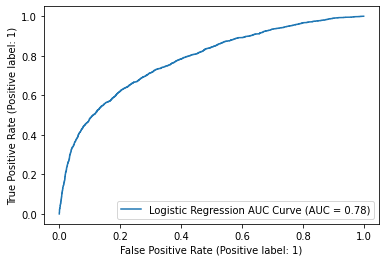

In [28]:
# Add visualizations and save for inspection
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(final_model, X_test, y_test, name='Logistic Regression AUC Curve')
plt.savefig('/mnt/visualizations/tunerd_rf_ROC_Curve.png')

### Save Best Model

In [29]:
import pickle

# dump the model into a file
with open("../artifacts/hand_coded_model.bin", 'wb') as f_out:
    pickle.dump(final_model, f_out) # write final_model in .bin file
    f_out.close()  # close the file 

In [30]:
# Save Performance to Domino Stats
import json
with open('/mnt/dominostats.json', 'w') as f:
    f.write(json.dumps( {"AUC": final_auc}))